# World Cup 2022 Pool Analysis


With the 2022 World Cup just around the corner, I wanted to apply my learnings from CSE 6040 to a real dataset.My workplace is incredibly invested in Football/Soccer. Every year, we compete in a variety of Fantasy League games which include the English Premier League/EUROS/World Cup and more. This year, I reached out to our pool organizer (the person that collects each participants predictions and 'donations') if I could use the data and run several types of analysis.

After a stakeholder meetings, a few requirements were identified:
1. Ensuring PII (personally identifiable information) info is encrypted and shared to the right users
2. Find a data source to extract world cup group standings (trickier than expected)
3. Calculate each participants group stage
4. Report pool standings

Due to time/resource constraints, this notebook scope is limited to:
1. Scraping Group Standings
2. Calculating participant standings based solely on group stage results

# This notebook is divided into several parts:

1. Scraping World Cup 2022 Group Standings on Wikipedia
2. Ingesting Participant Pool Data + Data Analysis
3. Group Stage Scoring
4. Reporting and Future Iterations

In [1]:
#importing libraries for project
import urllib.request
import os
from bs4 import BeautifulSoup as bs
import re
import pandas as pd 

## Part 1 - Scraping World Cup 2022 Group Standings

 Notes: This task was much harder than anticipated. The approach here was to find a reliable Data Source and extract into a python Dictionary
 
I started by googling 'Free World Cup 2022 API' and stumbled upon:
 
#### Free-API-World Cup: https://github.com/raminmr/free-api-worldcup2022
 
Challenge: Unable to setup connection with python Request Library (more front-end programming experience was needed and I've never worked with CURL so this was a failure.
 
Result :( 
 
#### Livesport: https://www.livesport.com/en/soccer/world/world-cup/standings/#/2/8/zkyDYRLU/table
 
Challenge: Identifying the tags and classes proved time consuming because the site was dynamic and required more advanced knowledge of web scraping to execute
 
Result :(
 
#### By this stage, I lost quite a bit of hope :( 
 
 I took a break after and reflected on the experience
 1. The issue was that many sites have sophisticated front end configurations which made scraping a tedious exercise
 2. A new requirement to this task would have to be, page/site needed to be static and contain mainly basic html/css for scraping to succeed as an ingestion step

Taking those learnings into consideration, I zeroed in on a particular site
 
#### Wikipedia: https://en.wikipedia.org/wiki/Template:2022_FIFA_World_Cup_group_tables
 
#### Challenge: Understanding enough of Beautiful Soup to extract what I needed and use my knowledge of Python data structures (List/Dictionaries) to scrape the data points I needed
 
#### Result: Success :)
 
#### Callouts: Scraping live webpages vs API run the risk of a webpage changing its page structure which might lead to broken ingestion steps in the future so mitigation steps required here!

In [2]:
#load html code from url
page=urllib.request.urlopen("https://en.wikipedia.org/wiki/Template:2022_FIFA_World_Cup_group_tables")
soup=bs(page,"html.parser")

#each group is organized into a table, identified by class wikitable

#step 1: need to scrape all wikitables
group_table=soup.findAll('table', attrs = {'class':'wikitable'})

#step 2: how do i extract the team names in each group?
#need to filter on th and scope:row
group_teams=group_table[0].findAll('th', attrs = {'scope':'row'})
print(f"The total tables scraped were {len(group_table)}")
# 8 makes sense because the world cup has a total of 8 groups (Group A - Group H) so we should expect to find 8 tables


The total tables scraped were 8


In [3]:
print(f"First table sample with a key of 0")
print(f"This dictionary value contains the team ranked first in group A \n {group_teams[0]}")

First table sample with a key of 0
This dictionary value contains the team ranked first in group A 
 <th scope="row" style="text-align: left; white-space:nowrap;font-weight: normal;background-color:#BBF3BB;"><span style="white-space:nowrap"><span class="flagicon"><img alt="" class="thumbborder" data-file-height="600" data-file-width="900" decoding="async" height="15" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/20/Flag_of_the_Netherlands.svg/23px-Flag_of_the_Netherlands.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/20/Flag_of_the_Netherlands.svg/35px-Flag_of_the_Netherlands.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/2/20/Flag_of_the_Netherlands.svg/45px-Flag_of_the_Netherlands.svg.png 2x" width="23"/> </span><a href="/wiki/Netherlands_national_football_team" title="Netherlands national football team">Netherlands</a></span>
</th>


In [4]:
#step 3: how do i extract only the team name
#need to use text method
print(f"Team ranked first in group A is{group_teams[0].text}")
#to validate: please go to the wikipage https://en.wikipedia.org/wiki/Template:2022_FIFA_World_Cup_group_tables
#and inspect the result to confirm
#notice that the printed string has a space embedded in the text so some cleaning steps are required

Team ranked first in group A is Netherlands



In [5]:
def clean_text(team_string):
  remove_escape=team_string[1:len(team_string)-1]
  replace_A=remove_escape.replace('(A)',"")
  no_lead_trail_spaces=replace_A.strip()
  return no_lead_trail_spaces

In [6]:
#step 4: lets loop over each table and extract only the first 2 teams in the group as a list and store them inside a dictionary called results
results={}
grouplist=['Group_A','Group_B','Group_C','Group_D','Group_E','Group_F','Group_G','Group_H']

for group_index in range(len(group_table)):
  my_group=group_table[group_index].findAll('th', attrs = {'scope':'row'})
  results[grouplist[group_index]]=[clean_text(my_group[0].text),clean_text(my_group[1].text)]

# pd.DataFrame([results])
results

{'Group_A': ['Netherlands', 'Senegal'],
 'Group_B': ['England', 'United States'],
 'Group_C': ['Argentina', 'Poland'],
 'Group_D': ['France', 'Australia'],
 'Group_E': ['Japan', 'Spain'],
 'Group_F': ['Morocco', 'Croatia'],
 'Group_G': ['Brazil', 'Switzerland'],
 'Group_H': ['Portugal', 'South Korea']}

# Part 2 - Ingesting Participant Pool Data + Data Analysis

#### Credit: Thanks Maria for providing me the participant list and data!

Before reading the data, I had to do some preprocessing on the raw data to make it 'Halal/Kosher' for the CSE 6040 project

The proprecessing steps didn't make it to this project but for clarity, I've listed the preprocessing steps below

Tool Used: Alteryx + R

Output: Final-Pool-Encrypted-Corrected.csv

Steps:
1. Read participant data as an excel file
2. Filter excel file to keep only data points with completed data (include the top 2 teams from each group and predicted round of 16 matches)
3. Removing Trailing and Leading Whitespaces on all columns
3. Hash the participant name using SHA-256 Algorithm standard (R function)
4. Output csv file containing only the hashed name and group picks as a seperate column (We're using this!)
5. Output another csv file containing mappings between Participant Name -> Encrypted Name (Organizer keeps this!)

In [7]:
#ingest player picks data for group stage
# I have backup data on github in case this doesn't work
# player_url="https://raw.githubusercontent.com/Cerivitus/world-cup-2022-pool/main/Final-Pool-Encrypted-Corrected.csv"
# player_picks=pd.read_csv(player_url)

#use the csv file in vocareum project
player_picks =pd.read_csv('Final-Pool-Encrypted-Corrected-Github.csv')

print(f"Here is a sample of the data")
player_picks.head()


Here is a sample of the data


,Player_ID,Encrypted_Name,A1,A2,B1,B2,C1,C2,D1,D2,...,61-Away,62-Home,62-Away,63-Home,63-Away,64-Home,64-Away,winner,second,third
0,1,38ec07443ea9368403f62411dcbb300ba270bb5cd61588...,Netherlands,Senegal,England,US,Argentina,Poland,France,Denmark,...,Brazil,France,Uruguay,Brazil,Uruguay,Argentina,France,Argentina,France,Uruguay
1,2,772c22e44cebd29cba334b88a511c139f84971cd08b898...,Netherlands,Senegal,England,US,Argentina,Poland,France,Denmark,...,Brazil,England,Croatia,Argentina,Croatia,Brazil,England,England,Brazil,Argentina
2,3,125f64e756e448257bc9863e99923f98e602f724e4bade...,Netherlands,Ecuador,England,US,Argentina,Mexico,France,Denmark,...,Brazil,France,Germany,Argentina,Germany,Brazil,France,Brazil,France,Germany
3,4,2022b2e18fbfe9cc10748775c3e60832543c1c55e9d363...,Netherlands,Qatar,England,Wales,Argentina,Poland,France,Denmark,...,Spain,France,Portugal,Netherlands,France,Spain,Portugal,Spain,Portugal,France
4,5,8ed7a4700e25b60de58a803a2ddcc6e37236c29854a876...,Netherlands,Ecuador,England,US,Argentina,Mexico,France,Australia,...,Germany,France,Portugal,Argentina,Portugal,Germany,France,Germany,France,Portugal


In [8]:
#need to replace US in raw data to United States to fit Wikipedia naming convention
player_picks=player_picks.replace('US', 'United States')

#take only group stage picks
cols=player_picks.columns[1:18]

group_stage_df=player_picks[cols]

#set the index as encrypted name
group_stage_df=group_stage_df.set_index('Encrypted_Name')


In [9]:
group_stage_df.head()

,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,F1,F2,G1,G2,H1,H2
Encrypted_Name,,,,,,,,,,,,,,,,
38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008,Netherlands,Senegal,England,United States,Argentina,Poland,France,Denmark,Germany,Spain,Croatia,Belgium,Brazil,Switzerland,Uruguay,Portugal
772c22e44cebd29cba334b88a511c139f84971cd08b8989c3edc408fdf76f797,Netherlands,Senegal,England,United States,Argentina,Poland,France,Denmark,Germany,Spain,Croatia,Belgium,Brazil,Switzerland,Portugal,Uruguay
125f64e756e448257bc9863e99923f98e602f724e4bade5eab78e12eb5d1ef1e,Netherlands,Ecuador,England,United States,Argentina,Mexico,France,Denmark,Spain,Germany,Belgium,Croatia,Brazil,Switzerland,Portugal,Uruguay
2022b2e18fbfe9cc10748775c3e60832543c1c55e9d3635f32d453d21807af51,Netherlands,Qatar,England,Wales,Argentina,Poland,France,Denmark,Spain,Germany,Belgium,Croatia,Brazil,Serbia,Portugal,Ghana
8ed7a4700e25b60de58a803a2ddcc6e37236c29854a876c2024d6daf6e7b5640,Netherlands,Ecuador,England,United States,Argentina,Mexico,France,Australia,Germany,Spain,Canada,Belgium,Brazil,Serbia,Portugal,Uruguay


In [10]:
print("This is my current df")
group_stage_df.head(1)

This is my current df


,A1,A2,B1,B2,C1,C2,D1,D2,E1,E2,F1,F2,G1,G2,H1,H2
Encrypted_Name,,,,,,,,,,,,,,,,
38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008,Netherlands,Senegal,England,United States,Argentina,Poland,France,Denmark,Germany,Spain,Croatia,Belgium,Brazil,Switzerland,Uruguay,Portugal


In [11]:
#recall that my final output from Wikipedia looks like this
results

{'Group_A': ['Netherlands', 'Senegal'],
 'Group_B': ['England', 'United States'],
 'Group_C': ['Argentina', 'Poland'],
 'Group_D': ['France', 'Australia'],
 'Group_E': ['Japan', 'Spain'],
 'Group_F': ['Morocco', 'Croatia'],
 'Group_G': ['Brazil', 'Switzerland'],
 'Group_H': ['Portugal', 'South Korea']}

In [12]:
#'I need to convert my player picks data to match the results dictionary'
#create new columns that match results dict
for group in grouplist:
  letter=group[-1]
  group_stage_df[group]= group_stage_df[[f"{letter}1", f"{letter}2"]].values.tolist()

group_stage_df=group_stage_df[grouplist]

group_stage_df.head()

,Group_A,Group_B,Group_C,Group_D,Group_E,Group_F,Group_G,Group_H
Encrypted_Name,,,,,,,,
38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008,"[Netherlands, Senegal]","[England, United States]","[Argentina, Poland]","[France, Denmark]","[Germany, Spain]","[Croatia, Belgium]","[Brazil, Switzerland]","[Uruguay, Portugal]"
772c22e44cebd29cba334b88a511c139f84971cd08b8989c3edc408fdf76f797,"[Netherlands, Senegal]","[England, United States]","[Argentina, Poland]","[France, Denmark]","[Germany, Spain]","[Croatia, Belgium]","[Brazil, Switzerland]","[Portugal, Uruguay]"
125f64e756e448257bc9863e99923f98e602f724e4bade5eab78e12eb5d1ef1e,"[Netherlands, Ecuador]","[England, United States]","[Argentina, Mexico]","[France, Denmark]","[Spain, Germany]","[Belgium, Croatia]","[Brazil, Switzerland]","[Portugal, Uruguay]"
2022b2e18fbfe9cc10748775c3e60832543c1c55e9d3635f32d453d21807af51,"[Netherlands, Qatar]","[England, Wales]","[Argentina, Poland]","[France, Denmark]","[Spain, Germany]","[Belgium, Croatia]","[Brazil, Serbia]","[Portugal, Ghana]"
8ed7a4700e25b60de58a803a2ddcc6e37236c29854a876c2024d6daf6e7b5640,"[Netherlands, Ecuador]","[England, United States]","[Argentina, Mexico]","[France, Australia]","[Germany, Spain]","[Canada, Belgium]","[Brazil, Serbia]","[Portugal, Uruguay]"


### Let's do Data Analysis!


### Viz 1: Based on the player picks dataframe, what are people predicting as winner of the World Cup?
#### Output: Bar chart stacked highest to lowest winner

<AxesSubplot:xlabel='winner'>

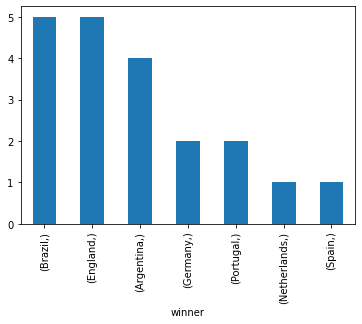

In [13]:
import pandas as pd

# create a dataframe that contains only the winner column and the frequency of each winner
df_winner =player_picks[["winner"]].value_counts()
# plot the bar chart
df_winner.plot.bar()


Based on the player picks data frame, its a tie between Brazil and England with 5 votes each.

### Viz 2: Based on the group_stage dataframe, which group do people have a high consensus in the top 2 (Above 90%)?
#### Output: Table

In [14]:
# use describe method to return frequency of counts for each group
summary_df=group_stage_df.describe()

# transpose to standard table format
transposed_summary=summary_df.T

#create percentage column
transposed_summary['percentage']=transposed_summary['freq']/transposed_summary['count']*100

#sort values based on highest to lowest percentage
transposed_summary=transposed_summary.sort_values(by=['percentage'],ascending=False)

transposed_summary

,count,unique,top,freq,percentage
Group_D,20,3,"[France, Denmark]",16,80.0
Group_A,20,4,"[Netherlands, Senegal]",15,75.0
Group_C,20,2,"[Argentina, Mexico]",14,70.0
Group_H,20,5,"[Portugal, Uruguay]",12,60.0
Group_B,20,3,"[England, Wales]",10,50.0
Group_E,20,4,"[Germany, Spain]",10,50.0
Group_G,20,3,"[Brazil, Switzerland]",10,50.0
Group_F,20,5,"[Belgium, Croatia]",9,45.0


None of the group winners had a predicted percentage above 90%, the group with the highest consensus (80%) is Group D with France and Denmark predicted to advance.

### Viz 3: Based on the group stage dataframe, which group do people have the lowest confidence in the top 2? (groups with the lowest percentage of consensus )
#### Output: List

Based on the table above, Group_F had the lowest consensus (less than 50%) for its top two teams [Belgium, Croatia].
Let's take a look at what people were predicting here.

In [15]:
group_f=group_stage_df[['Group_F']]
#turn df to a list
f_list=tuple(group_f['Group_F'].tolist())
#get unique data using list comprehension
unique_data = [list(x) for x in set(tuple(x) for x in f_list)]
unique_data

[['Croatia', 'Canada'],
 ['Belgium', 'Canada'],
 ['Croatia', 'Belgium'],
 ['Canada', 'Belgium'],
 ['Belgium', 'Croatia']]

For context, Group F also contains Morocco which wasn't considered in any participant predictions.
The 5 predictions contained a combination of Belgium, Canada and Croatia

# Part 3 - Group Stage Scoring Algorithm

Here's the approach
    1. Create a default dictionary that stores the scores for each participant by group (8 groups)
    2. Create a loop that goes through the scoring dictionary created in step 1
        2.1 For each participant, loop through each key (group)
        2.2 For each key, extract the participants predictions (list) and result (list)
        2.3 Apply scoring algorithm
            2.3.1 If both lists contain the same set of items (this means they predicted the 2 teams correctly)
                  2.3.1.1 Check if the teams are in the correct order : if true, award 10 pts else 4 pts
            2.3.2 If false, find the intersect (what team appears in both lists) and store in another list
                  2.3.2.1 Check if this intersect list is empty: if empty, award 0 points
                  2.3.2.2 If not empty, compare index of team in intersect list: if true, award 5 pts else 2 pts
        2.3.3 Update the dictionary for each participant containing each score
        2.3.4 Sum the scores and update the result_dict dictionary using encrypted_name as a key

In [16]:
#create a scoring dictionary
#the structure will be dict (encrypted_names) of dict(group) of ints
from collections import defaultdict

#create a dictionary of players
player_score = defaultdict(dict)

#use encrypted_name as keys
player_score=player_score.fromkeys(group_stage_df.index)


#create a dictionary of groups
group_score = defaultdict(int)

#use group names as keys
group_score=group_score.fromkeys(results.keys(),0)

#create scoring nested dictionary
scoring={k:group_score for k,v in player_score.items()}



In [17]:
#group scoring algorithm
#loop through scoring dictionary by player
#extract picks and result
#evaluate
# if set matches else 0:
# if set matches true then check order
# if check order is true = 5 pts, else 2
#update the scores for each group
#get all values in groups, sum them, and put into result_dict

result_dict={}

for player,groups in scoring.items():
  

  for group,score in groups.items():
    #extract player picks by group
    picks=group_stage_df.loc[[player]][group]

    #check if set matches
    
    if set(picks[0]) == set(results[group]):
       
       #check order
       if picks[0] == results[group]:
         score = 10
       else:
         score = 4

    else:
        
        #find the intersect of the set
        partial=list(set(picks[0]) & set(results[group]))
        
        #check if list is empty or not
        if len(partial) != 0:
          #store the index of the intersect value in 2 variables
          partial_order = picks[0].index(partial[0])
          result_order = results[group].index(partial[0])
        
          #if orders match, 5 points, else 2 points
        
          if partial_order == result_order:
            score = 5
          else:
            score = 2

        else:
          score = 0
    
    print(f" For {group}\n Player {player}\n Predicted:{picks[0]}\n Result:{results[group]}\n Score:{score}\n")
    
    #update groups dict
    groups[group]=score
    
  print(f" Player {player}\n Updated Score:{groups}\n")
  #You can check my scoring logic in action here!
  result_dict[player]=sum(groups.values())

 For Group_A
 Player 38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008
 Predicted:['Netherlands', 'Senegal']
 Result:['Netherlands', 'Senegal']
 Score:10

 For Group_B
 Player 38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008
 Predicted:['England', 'United States']
 Result:['England', 'United States']
 Score:10

 For Group_C
 Player 38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008
 Predicted:['Argentina', 'Poland']
 Result:['Argentina', 'Poland']
 Score:10

 For Group_D
 Player 38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008
 Predicted:['France', 'Denmark']
 Result:['France', 'Australia']
 Score:5

 For Group_E
 Player 38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008
 Predicted:['Germany', 'Spain']
 Result:['Japan', 'Spain']
 Score:5

 For Group_F
 Player 38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008
 Predicted:['Croatia', 'Belgium']
 Result:['Morocco', 'Croatia']
 Score:2

 For Group_G
 P

# Part 4 - Reporting and Future Iterations

Last step here is to visualize the results. Will create a simple bar chart to show who is leading

In [18]:
from datetime import datetime
from pytz import timezone

#generate a timestamp based on EST time
ts=pd.Timestamp.now(timezone('EST'))

#convert dictionary to dataframe and orient keys as my row (index)
group_score=pd.DataFrame.from_dict(result_dict, orient='index',columns=['Group_Score'])

#sort in descending order
group_score=group_score.sort_values(by='Group_Score', ascending=False)

#add timestamp
group_score['Reporting_Date']= ts
group_score['Encrypted_Name']= group_score.index

group_score

,Group_Score,Reporting_Date,Encrypted_Name
772c22e44cebd29cba334b88a511c139f84971cd08b8989c3edc408fdf76f797,57,2022-12-06 20:48:57.465117-05:00,772c22e44cebd29cba334b88a511c139f84971cd08b898...
e3e4480531d6677068e5d8e1c82c1d5e9834ed82cb5c29014df017e0adc1aae4,55,2022-12-06 20:48:57.465117-05:00,e3e4480531d6677068e5d8e1c82c1d5e9834ed82cb5c29...
38ec07443ea9368403f62411dcbb300ba270bb5cd61588381e01e22a05adb008,54,2022-12-06 20:48:57.465117-05:00,38ec07443ea9368403f62411dcbb300ba270bb5cd61588...
8a9017c181c938deb8026506b42183fc95bb8883220d098fbcb801b47480b813,54,2022-12-06 20:48:57.465117-05:00,8a9017c181c938deb8026506b42183fc95bb8883220d09...
764abe59d9d9e1066bd85fc9ae139e822fbb120b9bbdc95c92bbfa290115b262,50,2022-12-06 20:48:57.465117-05:00,764abe59d9d9e1066bd85fc9ae139e822fbb120b9bbdc9...
d33f495445cba37a745d06fe5a1eb430bb6dd09a0878ce2b5a80e68e187b0904,50,2022-12-06 20:48:57.465117-05:00,d33f495445cba37a745d06fe5a1eb430bb6dd09a0878ce...
02a445665dd7a2ffb284f98aac3dcf0f09f7813ab6da80d157470318cf295201,50,2022-12-06 20:48:57.465117-05:00,02a445665dd7a2ffb284f98aac3dcf0f09f7813ab6da80...
f651af8b07e29c265f80ddea7f44200f9f61ac6dde5589aaaa1e8299220b057c,47,2022-12-06 20:48:57.465117-05:00,f651af8b07e29c265f80ddea7f44200f9f61ac6dde5589...
59af4d8274c3db36de829cd3db7166d48e83321ebbc11d1ba4c2fffdd97b1053,47,2022-12-06 20:48:57.465117-05:00,59af4d8274c3db36de829cd3db7166d48e83321ebbc11d...
125f64e756e448257bc9863e99923f98e602f724e4bade5eab78e12eb5d1ef1e,47,2022-12-06 20:48:57.465117-05:00,125f64e756e448257bc9863e99923f98e602f724e4bade...


In [19]:
# create a dataframe that contains encrypted name and group_score
final_group_score =group_score[['Encrypted_Name','Group_Score']]

In [20]:
#high level stats
final_group_score.describe()

,Group_Score
count,20.000000
mean,45.600000
std,6.660172
min,32.000000
25%,41.750000
50%,46.000000
75%,50.000000
max,57.000000


Overall, the average score for participants the group stage is 45.6 pts with a median of 46 pts and a max of 57 pts

<AxesSubplot:>

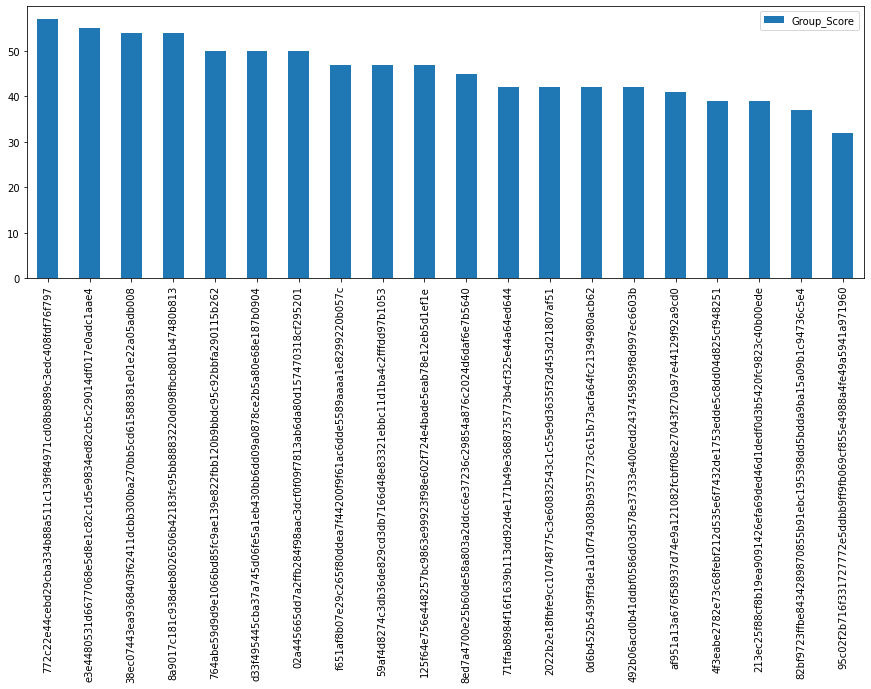

In [21]:
# plot the bar chart
final_group_score.plot.bar(figsize=(15, 5))

# Future Iterations

This was a labour of love and I wish I had more time to spend on it. I learned quite a lot about scraping/data cleaning/data encryption/scoring algorithms and hope you enjoyed learning along with me.

Below is my to do list as a follow up. While I may not be working on the FIFA 2022 World Cup data, I do have plans to use some of what I learned here in the Fantasy Premier League when it restarts end of Dec 2022 with the goal of building a Machine Learning player prediction model

# Given more time, these would be my next steps
1. Using the final group standings, construct a dictionary that contains each round of 16 matches
2. Prep player picks to include round of 16 fixtures (matches 49 - matches 56)
3. Do scoring for knockout stage
4. Merge group and knockout stage scoring dfs
5. Calculate the total scoring from both sections